# import

In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [18]:
df = pd.read_excel('datafix_watermeter.xlsx', dtype={"nsb": str})
df = df.dropna(axis=1, how="all")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,nsb,periode,pakai
0,0104433255,201504,0
1,0104433255,201505,0
2,0104433255,201506,0
3,0104433255,201507,0
4,0104433255,201508,0


# eda

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5393 entries, 0 to 5392
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   nsb          5393 non-null   int64 
 1   periode      5393 non-null   int64 
 2   pakai        5393 non-null   int64 
 3   Unnamed: 16  1 non-null      object
dtypes: int64(3), object(1)
memory usage: 168.7+ KB


In [61]:
df['periode'].min()

201504

In [62]:
df['periode'].max()

202504

In [63]:
# Find and print duplicated rows
duplicated_rows = df[df.duplicated(keep=False)]
duplicated_rows

,nsb,periode,pakai
33,104433255,201801,2
34,104433255,201801,2
35,104433255,201802,0
36,104433255,201802,0
37,104433255,201803,0
...,...,...,...
5312,104434133,201810,5
5313,104434133,201811,4
5314,104434133,201811,4
5315,104434133,201812,4


In [64]:
df['periode']

0       201504
1       201505
2       201506
3       201507
4       201508
         ...  
5388    202412
5389    202501
5390    202502
5391    202503
5392    202504
Name: periode, Length: 5393, dtype: int64

In [65]:
df = df.drop_duplicates(keep=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4405 entries, 0 to 5392
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   nsb      4405 non-null   int64
 1   periode  4405 non-null   int64
 2   pakai    4405 non-null   int64
dtypes: int64(3)
memory usage: 137.7 KB


In [69]:
df['nsb']

0       104433255
1       104433255
2       104433255
3       104433255
4       104433255
          ...    
5388    104434133
5389    104434133
5390    104434133
5391    104434133
5392    104434133
Name: nsb, Length: 4405, dtype: int64

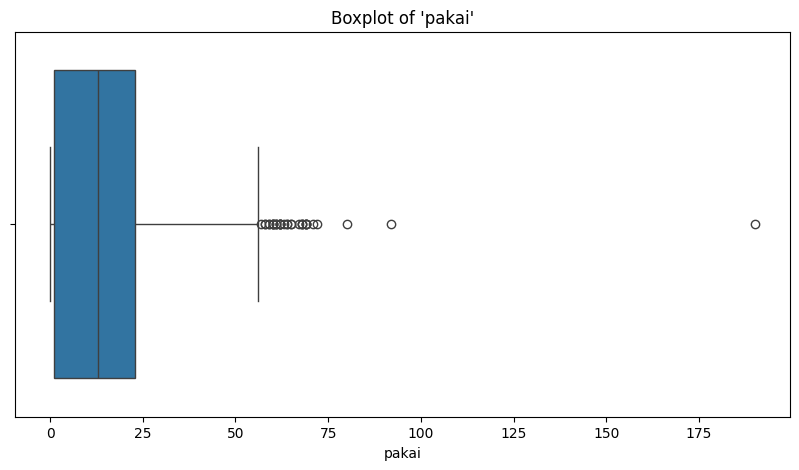

In [67]:
df['periode'] = pd.to_datetime(df['periode'])

# --- 1. Boxplot of 'pakai' (overall or per 'nsb') ---
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['pakai'])
plt.title("Boxplot of 'pakai'")
plt.show()

In [68]:
df['periode']

0      1970-01-01 00:00:00.000201504
1      1970-01-01 00:00:00.000201505
2      1970-01-01 00:00:00.000201506
3      1970-01-01 00:00:00.000201507
4      1970-01-01 00:00:00.000201508
                    ...             
5388   1970-01-01 00:00:00.000202412
5389   1970-01-01 00:00:00.000202501
5390   1970-01-01 00:00:00.000202502
5391   1970-01-01 00:00:00.000202503
5392   1970-01-01 00:00:00.000202504
Name: periode, Length: 4405, dtype: datetime64[ns]

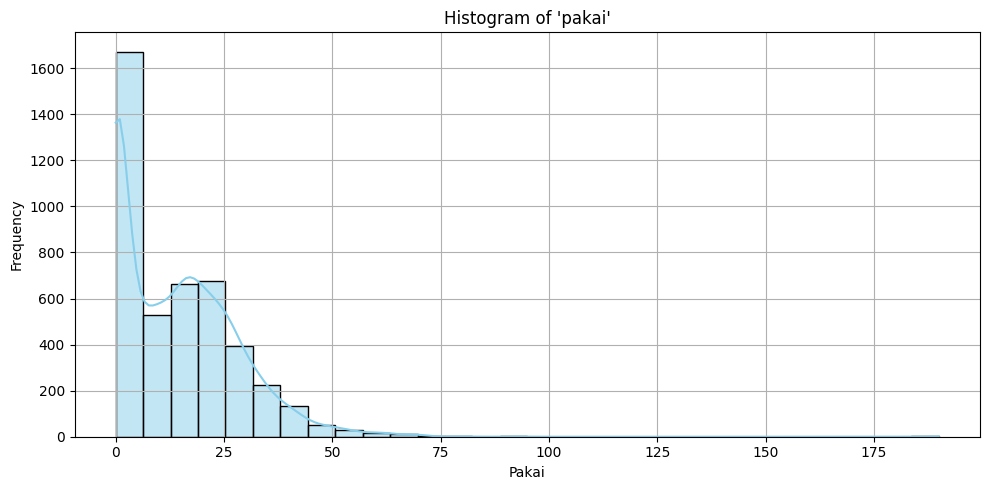

In [56]:
plt.figure(figsize=(10, 5))
sns.histplot(df['pakai'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Histogram of 'pakai'")
plt.xlabel("Pakai")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
df['periode']

0      1970-01-01 00:00:00.000201504
1      1970-01-01 00:00:00.000201505
2      1970-01-01 00:00:00.000201506
3      1970-01-01 00:00:00.000201507
4      1970-01-01 00:00:00.000201508
                    ...             
5388   1970-01-01 00:00:00.000202412
5389   1970-01-01 00:00:00.000202501
5390   1970-01-01 00:00:00.000202502
5391   1970-01-01 00:00:00.000202503
5392   1970-01-01 00:00:00.000202504
Name: periode, Length: 4405, dtype: datetime64[ns]

# prepro

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4405 entries, 0 to 5392
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   nsb      4405 non-null   int64         
 1   periode  4405 non-null   datetime64[ns]
 2   pakai    4405 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 137.7 KB


In [35]:
# # Compute IQR
# Q1 = df['pakai'].quantile(0.25)
# Q3 = df['pakai'].quantile(0.75)
# IQR = Q3 - Q1

# # Define lower and upper bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter out outliers
# df = df[(df['pakai'] >= lower_bound) & (df['pakai'] <= upper_bound)]


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4405 entries, 0 to 5392
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   nsb      4405 non-null   int64         
 1   periode  4405 non-null   datetime64[ns]
 2   pakai    4405 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 137.7 KB


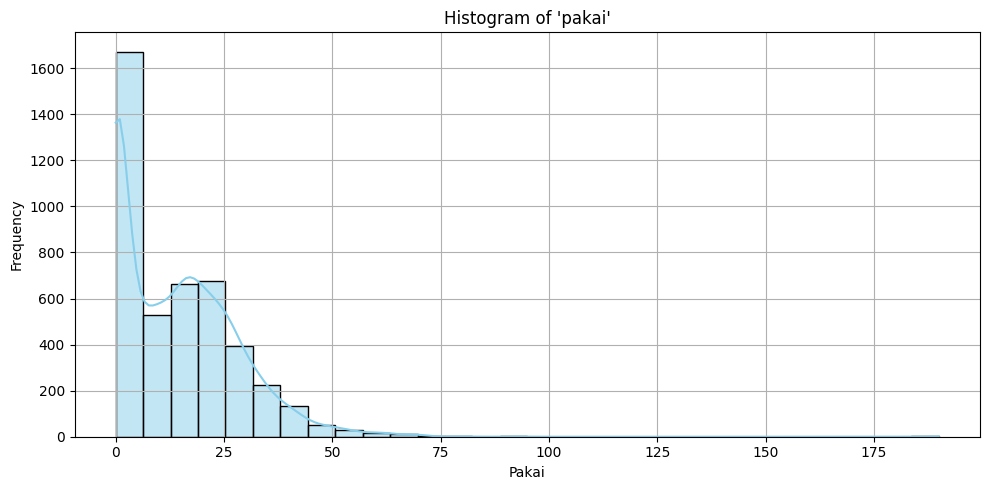

In [37]:
plt.figure(figsize=(10, 5))
sns.histplot(df['pakai'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Histogram of 'pakai'")
plt.xlabel("Pakai")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
df = df.sort_values(['nsb', 'periode'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4405 entries, 0 to 5392
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   nsb      4405 non-null   int64         
 1   periode  4405 non-null   datetime64[ns]
 2   pakai    4405 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 137.7 KB


In [39]:
# Prepare empty lists to collect results
decomp_results = []

# Loop through each customer
for customer_id, group in df.groupby('nsb'):
    group = group.set_index('periode').sort_index()
    if len(group) >= 24:  # STL needs enough data points (at least 2 periods)
        stl = STL(group['pakai'], period=12)
        result = stl.fit()
        temp = group.copy()
        temp['trend'] = result.trend
        temp['seasonal'] = result.seasonal
        temp['resid'] = result.resid
        temp['nsb'] = customer_id
        decomp_results.append(temp.reset_index())
    # else: skip customers with too few data points

# Combine all results into a single DataFrame
df_decomp = pd.concat(decomp_results, ignore_index=True)

# Show the first few rows
df_decomp.head()

,periode,nsb,pakai,trend,seasonal,resid
0,1970-01-01 00:00:00.000201504,104433255,0,1.219121,-1.269019,0.049898
1,1970-01-01 00:00:00.000201505,104433255,0,1.453108,-1.665294,0.212186
2,1970-01-01 00:00:00.000201506,104433255,0,1.681442,-2.485063,0.803621
3,1970-01-01 00:00:00.000201507,104433255,0,1.902291,0.581016,-2.483307
4,1970-01-01 00:00:00.000201508,104433255,0,2.113442,-1.978895,-0.134547


In [ ]:
# Save trend, seasonal, and resid columns into separate DataFrames
trend_df = df_decomp[['nsb', 'periode', 'trend']].copy()
seasonal_df = df_decomp[['nsb', 'periode', 'seasonal']].copy()
resid_df = df_decomp[['nsb', 'periode', 'resid']].copy()

# Example: Split each DataFrame into train and test (80% train, 20% test) for each customer
def split_train_test(df, value_col, test_size=0.2):
    train_list = []
    test_list = []
    for nsb, group in df.groupby('nsb'):
        group = group.sort_values('periode')
        n = len(group)
        split_idx = int(n * (1 - test_size))    
        train_list.append(group.iloc[:split_idx])
        test_list.append(group.iloc[split_idx:])
    train_df = pd.concat(train_list, ignore_index=True)
    test_df = pd.concat(test_list, ignore_index=True)
    return train_df, test_df

trend_train, trend_test = split_train_test(trend_df, 'trend')
seasonal_train, seasonal_test = split_train_test(seasonal_df, 'seasonal')
resid_train, resid_test = split_train_test(resid_df, 'resid')

# Show the shape of each split as a check
print("Trend train:", trend_train.shape, "Trend test:", trend_test.shape)
print("Seasonal train:", seasonal_train.shape, "Seasonal test:", seasonal_test.shape)
print("Resid train:", resid_train.shape, "Resid test:", resid_test.shape)

Trend train: (3514, 3) Trend test: (891, 3)
Seasonal train: (3514, 3) Seasonal test: (891, 3)
Resid train: (3514, 3) Resid test: (891, 3)


In [41]:
# from sklearn.preprocessing import MinMaxScaler

# # Function to normalize a value column per customer
# def normalize_per_customer(df, value_col):
#     scaler_dict = {}
#     norm_list = []
#     for nsb, group in df.groupby('nsb'):
#         scaler = MinMaxScaler()
#         values = group[[value_col]].values
#         norm_values = scaler.fit_transform(values)
#         group[value_col + '_norm'] = norm_values
#         scaler_dict[nsb] = scaler
#         norm_list.append(group)
#     norm_df = pd.concat(norm_list, ignore_index=True)
#     return norm_df, scaler_dict

# # Normalize each dataset
# trend_train, trend_scaler = normalize_per_customer(trend_train, 'trend')
# trend_test, _ = normalize_per_customer(trend_test, 'trend')

# seasonal_train, seasonal_scaler = normalize_per_customer(seasonal_train, 'seasonal')
# seasonal_test, _ = normalize_per_customer(seasonal_test, 'seasonal')

# resid_train, resid_scaler = normalize_per_customer(resid_train, 'resid')
# resid_test, _ = normalize_per_customer(resid_test, 'resid')

# # Show head of normalized trend_train
# trend_train.head()

# modelling

Epoch 1/20, Loss: 541.1686
Epoch 2/20, Loss: 204.2852
Epoch 3/20, Loss: 22.0442
Epoch 4/20, Loss: 60.6098
Epoch 5/20, Loss: 76.8803
Epoch 6/20, Loss: 290.5469
Epoch 7/20, Loss: 161.2858
Epoch 8/20, Loss: 0.0147
Epoch 9/20, Loss: 127.3960
Epoch 10/20, Loss: 1.3038
Epoch 11/20, Loss: 0.8797
Epoch 12/20, Loss: 0.0081
Epoch 13/20, Loss: 0.0083
Epoch 14/20, Loss: 36.8916
Epoch 15/20, Loss: 15.7427
Epoch 16/20, Loss: 42.4130
Epoch 17/20, Loss: 2.8960
Epoch 18/20, Loss: 0.2663
Epoch 19/20, Loss: 0.1567
Epoch 20/20, Loss: 0.0061


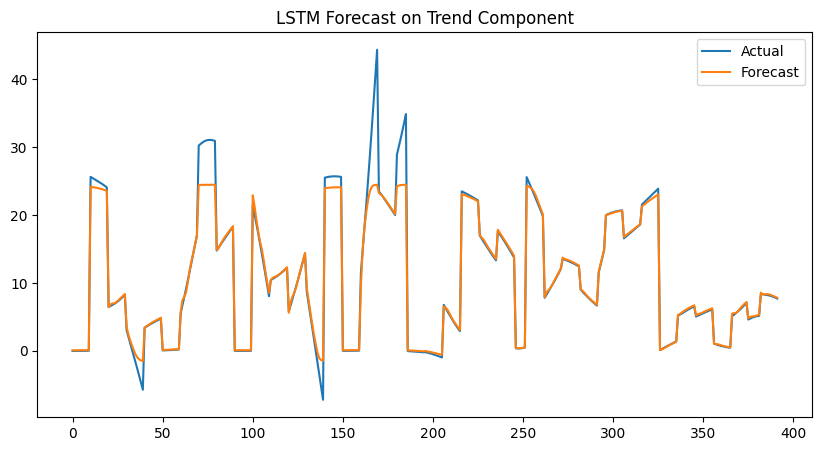

In [42]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# --- LSTM Model Definition ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# --- Prepare Data for LSTM ---
def create_sequences(data, seq_length=12, value_col='trend'):
    xs, ys = [], []
    for nsb, group in data.groupby('nsb'):
        group = group.sort_values('periode')
        values = group[value_col].values
        for i in range(len(values) - seq_length):
            xs.append(values[i:i+seq_length])
            ys.append(values[i+seq_length])
    return np.array(xs), np.array(ys)

# Example: Use trend component for LSTM
seq_length = 12
X_train, y_train = create_sequences(trend_train, seq_length, value_col='trend')
X_test, y_test = create_sequences(trend_test, seq_length, value_col='trend')

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# --- Train LSTM ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# --- Forecast on Test Set ---
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()

# --- Inverse Transform (if needed) ---
# To get the original scale, use the scaler for each customer (optional, shown for one customer)
# Example for the first customer in test set:
# nsb_id = trend_test_norm['nsb'].iloc[0]
# scaler = trend_scaler[nsb_id]
# y_pred_inv = scaler.inverse_transform(y_pred)

# --- Plot Forecast vs Actual ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Forecast')
plt.legend()
plt.title('LSTM Forecast on Trend Component')
plt.show()

In [43]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# If you get an error, use: rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100  # add small value to avoid division by zero

print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

R2 Score: 0.9519
MAE: 0.7363
RMSE: 2.1557
MAPE: 17004.97%


[Seasonal] Epoch 1/20, Loss: 146.5947
[Seasonal] Epoch 2/20, Loss: 0.7388
[Seasonal] Epoch 3/20, Loss: 1.1553
[Seasonal] Epoch 4/20, Loss: 0.1852
[Seasonal] Epoch 5/20, Loss: 1.5907
[Seasonal] Epoch 6/20, Loss: 0.7736
[Seasonal] Epoch 7/20, Loss: 1.5940
[Seasonal] Epoch 8/20, Loss: 0.7069
[Seasonal] Epoch 9/20, Loss: 0.1658
[Seasonal] Epoch 10/20, Loss: 2.4263
[Seasonal] Epoch 11/20, Loss: 1.4537
[Seasonal] Epoch 12/20, Loss: 9.7180
[Seasonal] Epoch 13/20, Loss: 0.8841
[Seasonal] Epoch 14/20, Loss: 0.7288
[Seasonal] Epoch 15/20, Loss: 24.1195
[Seasonal] Epoch 16/20, Loss: 0.5287
[Seasonal] Epoch 17/20, Loss: 0.2370
[Seasonal] Epoch 18/20, Loss: 0.8432
[Seasonal] Epoch 19/20, Loss: 0.0825
[Seasonal] Epoch 20/20, Loss: 0.3387


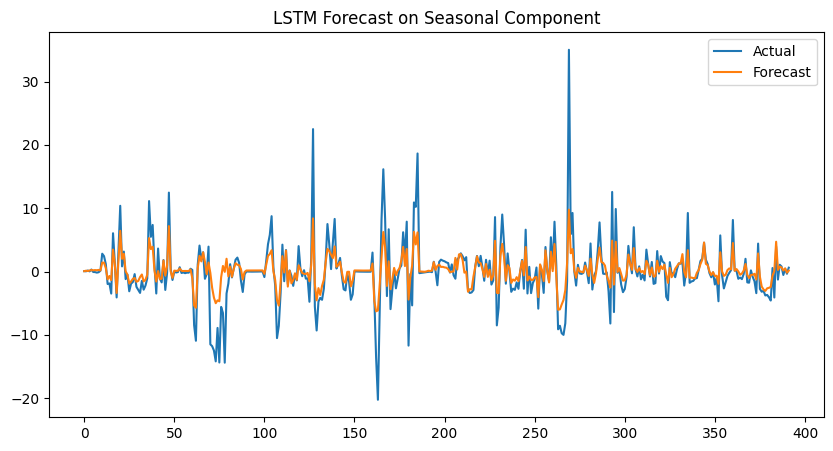

In [44]:
# --- LSTM for Seasonal Component ---
X_train_seasonal, y_train_seasonal = create_sequences(seasonal_train, seq_length, value_col='seasonal')
X_test_seasonal, y_test_seasonal = create_sequences(seasonal_test, seq_length, value_col='seasonal')

X_train_seasonal_tensor = torch.tensor(X_train_seasonal, dtype=torch.float32).unsqueeze(-1)
y_train_seasonal_tensor = torch.tensor(y_train_seasonal, dtype=torch.float32).unsqueeze(-1)
X_test_seasonal_tensor = torch.tensor(X_test_seasonal, dtype=torch.float32).unsqueeze(-1)
y_test_seasonal_tensor = torch.tensor(y_test_seasonal, dtype=torch.float32).unsqueeze(-1)

train_dataset_seasonal = TensorDataset(X_train_seasonal_tensor, y_train_seasonal_tensor)
test_dataset_seasonal = TensorDataset(X_test_seasonal_tensor, y_test_seasonal_tensor)
train_loader_seasonal = DataLoader(train_dataset_seasonal, batch_size=batch_size, shuffle=True)

model_seasonal = LSTMModel().to(device)
optimizer_seasonal = torch.optim.Adam(model_seasonal.parameters(), lr=0.001)

for epoch in range(epochs):
    model_seasonal.train()
    for xb, yb in train_loader_seasonal:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_seasonal.zero_grad()
        output = model_seasonal(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer_seasonal.step()
    print(f"[Seasonal] Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

model_seasonal.eval()
with torch.no_grad():
    y_pred_seasonal = model_seasonal(X_test_seasonal_tensor.to(device)).cpu().numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_test_seasonal, label='Actual')
plt.plot(y_pred_seasonal, label='Forecast')
plt.legend()
plt.title('LSTM Forecast on Seasonal Component')
plt.show()

In [45]:
# Calculate metrics
r2 = r2_score(y_test_seasonal, y_pred_seasonal)
mae = mean_absolute_error(y_test_seasonal, y_pred_seasonal)
rmse = np.sqrt(mean_squared_error(y_test_seasonal, y_pred_seasonal))
# If you get an error, use: rmse = np.sqrt(mean_squared_error(y_test_seasonal, y_pred_seasonal))
mape = np.mean(np.abs((y_test_seasonal - y_pred_seasonal) / (y_test_seasonal + 1e-8))) * 100  # add small value to avoid division by zero

print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

R2 Score: 0.6059
MAE: 1.6867
RMSE: 3.0265
MAPE: 1912.16%


[Residual] Epoch 1/20, Loss: 2.3255
[Residual] Epoch 2/20, Loss: 16.9823
[Residual] Epoch 3/20, Loss: 1.0527
[Residual] Epoch 4/20, Loss: 2.1571
[Residual] Epoch 5/20, Loss: 0.1654
[Residual] Epoch 6/20, Loss: 438.8137
[Residual] Epoch 7/20, Loss: 2.5944
[Residual] Epoch 8/20, Loss: 12.8720
[Residual] Epoch 9/20, Loss: 9.3570
[Residual] Epoch 10/20, Loss: 0.1615
[Residual] Epoch 11/20, Loss: 1.0181
[Residual] Epoch 12/20, Loss: 41.4563
[Residual] Epoch 13/20, Loss: 15.1653
[Residual] Epoch 14/20, Loss: 5.0276
[Residual] Epoch 15/20, Loss: 2.3070
[Residual] Epoch 16/20, Loss: 2.1471
[Residual] Epoch 17/20, Loss: 83.1492
[Residual] Epoch 18/20, Loss: 0.8986
[Residual] Epoch 19/20, Loss: 8.6104
[Residual] Epoch 20/20, Loss: 74.0738


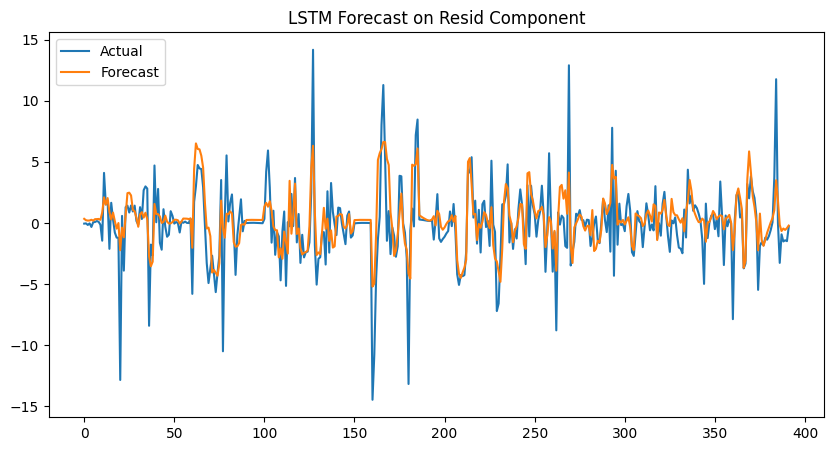

In [46]:
# --- LSTM for Residual Component ---
X_train_resid, y_train_resid = create_sequences(resid_train, seq_length, value_col='resid')
X_test_resid, y_test_resid = create_sequences(resid_test, seq_length, value_col='resid')

X_train_resid_tensor = torch.tensor(X_train_resid, dtype=torch.float32).unsqueeze(-1)
y_train_resid_tensor = torch.tensor(y_train_resid, dtype=torch.float32).unsqueeze(-1)
X_test_resid_tensor = torch.tensor(X_test_resid, dtype=torch.float32).unsqueeze(-1)
y_test_resid_tensor = torch.tensor(y_test_resid, dtype=torch.float32).unsqueeze(-1)

train_dataset_resid = TensorDataset(X_train_resid_tensor, y_train_resid_tensor)
test_dataset_resid = TensorDataset(X_test_resid_tensor, y_test_resid_tensor)
train_loader_resid = DataLoader(train_dataset_resid, batch_size=batch_size, shuffle=True)

model_resid = LSTMModel().to(device)
optimizer_resid = torch.optim.Adam(model_resid.parameters(), lr=0.001)

for epoch in range(epochs):
    model_resid.train()
    for xb, yb in train_loader_resid:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_resid.zero_grad()
        output = model_resid(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer_resid.step()
    print(f"[Residual] Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

model_resid.eval()
with torch.no_grad():
    y_pred_resid = model_resid(X_test_resid_tensor.to(device)).cpu().numpy()


import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_test_resid, label='Actual')
plt.plot(y_pred_resid, label='Forecast')
plt.legend()
plt.title('LSTM Forecast on Resid Component')
plt.show()

In [47]:
# Calculate metrics
r2 = r2_score(y_test_resid, y_pred_resid)
mae = mean_absolute_error(y_test_resid, y_pred_resid)
rmse = np.sqrt(mean_squared_error(y_test_resid, y_pred_resid))
# If you get an error, use: rmse = np.sqrt(mean_squared_error(y_test_resid, y_pred_resid))
mape = np.mean(np.abs((y_test_resid - y_pred_resid) / (y_test_resid + 1e-8))) * 100  # add small value to avoid division by zero

print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

R2 Score: 0.4659
MAE: 1.4636
RMSE: 2.2257
MAPE: 4272.41%


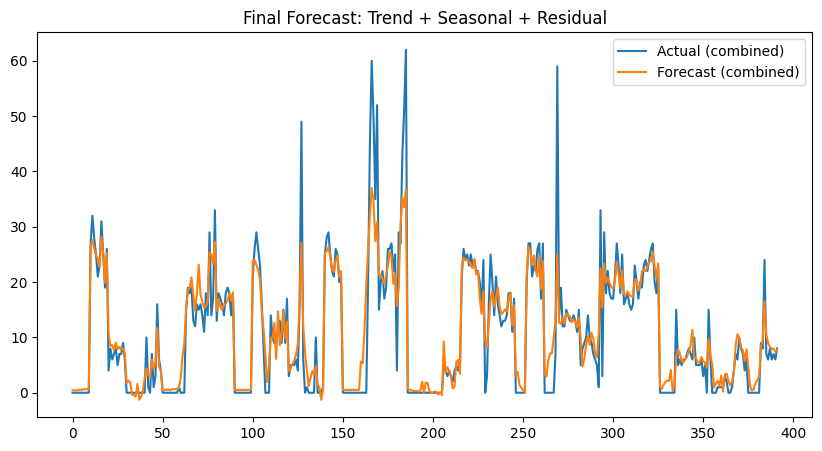

[Final Forecast] R2 Score: 0.8473
[Final Forecast] MAE: 2.5364
[Final Forecast] RMSE: 4.4993
[Final Forecast] MAPE: 6190271708.39%


In [48]:
min_len = min(len(y_pred), len(y_pred_seasonal), len(y_pred_resid))
y_pred_final = (
    y_pred[:min_len].flatten()
    + y_pred_seasonal[:min_len].flatten()
    + y_pred_resid[:min_len].flatten()
)

y_test_final = (
    y_test[:min_len].flatten()
    + y_test_seasonal[:min_len].flatten()
    + y_test_resid[:min_len].flatten()
)

# --- Plot combined forecast ---
plt.figure(figsize=(10,5))
plt.plot(y_test_final, label='Actual (combined)')
plt.plot(y_pred_final, label='Forecast (combined)')
plt.legend()
plt.title('Final Forecast: Trend + Seasonal + Residual')
plt.show()

# --- Evaluate combined forecast ---
r2_final = r2_score(y_test_final, y_pred_final)
mae_final = mean_absolute_error(y_test_final, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
mape_final = np.mean(np.abs((y_test_final - y_pred_final) / (y_test_final + 1e-8))) * 100

print(f"[Final Forecast] R2 Score: {r2_final:.4f}")
print(f"[Final Forecast] MAE: {mae_final:.4f}")
print(f"[Final Forecast] RMSE: {rmse_final:.4f}")
print(f"[Final Forecast] MAPE: {mape_final:.2f}%")